In [1]:
from __future__ import division, print_function
# coding=utf-8
import sys
import os, glob

from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename
from gevent.pywsgi import WSGIServer

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
#Adjusting the size of matplotlib
import matplotlib as mpl
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame
import io
import base64
import math
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score  # Can't be used here as it is used only in case of classifications
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

/home/tej/anaconda3/envs/tf/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
mpl.rc('figure', figsize=(8, 7))
# Adjusting the style of matplotlib
style.use('ggplot')

def get_data(stock, start, end):
    df = web.DataReader(stock, "yahoo", start, end)
    #df.set_index("Date", inplace=True)
    return df

def feature_engineer(dataframe):
    dfreg = dataframe.loc[:, ["Adj Close", "Volume"]]
    dfreg["HL_PCT"] = (dataframe["High"] - dataframe["Low"]) / dataframe["Close"] * 100.0
    dfreg["PCT_change"] = (dataframe["Close"] - dataframe["Open"]) / dataframe["Open"] * 100.0
    return dfreg

def preprocess_data(dataframe):
    dataframe.dropna(inplace=True)

    # cast out 1% of data for future prediction
    forecast_out = int(math.ceil(0.01*len(dataframe)))
    forecast_col = "Adj Close"
    dataframe["label"] = dataframe[forecast_col].shift(-forecast_out, axis=0) #axis=0 implies shift all columns

    X = np.array(dataframe.drop(["label"], axis=1))
    X = preprocessing.scale(X)

    X_lately = X[-forecast_out:]
    X_test = X[-(2*forecast_out):-forecast_out]
    X = X[:-forecast_out]

    y = np.array(dataframe['label'])
    y = y[:-forecast_out]
    y_test = np.array(dataframe[forecast_col])[-forecast_out:]

    return dataframe, X, y, X_test, y_test, X_lately

def train_model(regressor, X, y, X_test, y_test, hidden_size=(100,)):
    reg_model = None
    if regressor == "LinearRegression":
        reg_model = LinearRegression(n_jobs=-1)
    elif regressor == "PolynomialRegression":
        reg_model = make_pipeline(PolynomialFeatures(3), Ridge())
    elif regressor == "KNNRegression":
        reg_model = KNeighborsRegressor(n_neighbors=2)
    else: # regressor == "MLPRegression":
        reg_model = MLPRegressor()
    reg_model.fit(X, y)
    confidence_score = reg_model.score(X_test, y_test)
    return reg_model, confidence_score

def save_model(model, name):
    joblib.dump(model, "./"+name)

def load_model(name):
    model = joblib.load("./"+name)
    return model

def predict(reg_model, X_lately):
    forecast_set = reg_model.predict(X_lately)
    return forecast_set

def get_output_dataframe(dataframe, forecast_set):
    dataframe["Forecast"] = np.nan
    last_date = dataframe.iloc[-1].name
    #last_date = datetime.datetime.strptime(last_date, "%Y-%m-%d")
    last_unix = last_date
    next_unix = last_unix + datetime.timedelta(days=1)
    for i in forecast_set:
        next_date = next_unix
        next_unix += datetime.timedelta(days=1)
        dataframe.loc[next_date] = [np.nan for _ in range(len(dataframe.columns)-1)]+[i]
    return dataframe, dataframe["Forecast"].tail(len(forecast_set))

def get_plot_prediction_url(dataframe):
    img = io.BytesIO()
    dataframe['Adj Close'].tail(500).plot()
    dataframe['Forecast'].tail(500).plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()
    plt.savefig(img, format='png')
    img.seek(0)
    graph_url = base64.b64encode(img.getvalue()).decode()
    return 'data:image/png;base64,{}'.format(graph_url)


In [3]:
#temp start and end time
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 8, 30)
stock = "GOOG"
dfmain = get_data(stock, start, end)
dfmain.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,1169.469971,1152.959961,1157.260010,1168.890015,1226100.0,1168.890015
2019-08-27,1182.400024,1161.449951,1180.530029,1167.839966,1077200.0,1167.839966
2019-08-28,1176.420044,1157.300049,1161.709961,1171.020020,802000.0,1171.020020
2019-08-29,1196.060059,1181.119995,1181.119995,1192.849976,1088400.0,1192.849976
2019-08-30,1198.500000,1183.802979,1198.500000,1188.099976,1129800.0,1188.099976


In [4]:
dffeateng = feature_engineer(dfmain)
dffeateng.tail()

,Adj Close,Volume,HL_PCT,PCT_change
Date,,,,
2019-08-26,1168.890015,1226100.0,1.412452,1.004960
2019-08-27,1167.839966,1077200.0,1.793916,-1.074946
2019-08-28,1171.020020,802000.0,1.632764,0.801410
2019-08-29,1192.849976,1088400.0,1.252468,0.993124
2019-08-30,1188.099976,1129800.0,1.237019,-0.867753


In [5]:
dataframe, X, y, X_test, y_test, X_lately = preprocess_data(dffeateng)
print(X.shape, y.shape, X_test.shape, y_test.shape, X_lately.shape)

(2408, 4) (2408,) (25, 4) (25,) (25, 4)


In [6]:
model, score = train_model("LinearRegression", X, y, X_test, y_test)
print(score)

-8.330899363535933


In [7]:
forecast_set = predict(model, X_lately)
dffinal, dfpred = get_output_dataframe(dataframe, forecast_set)

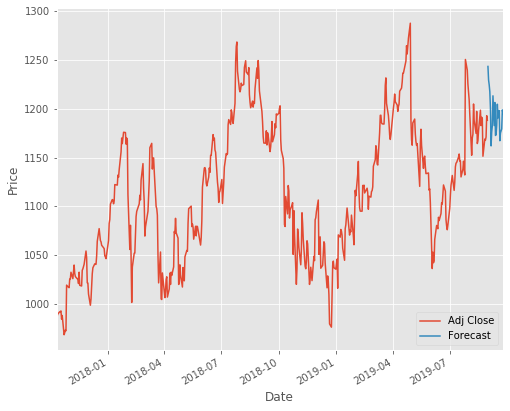

<Figure size 576x504 with 0 Axes>

In [8]:
url = get_plot_prediction_url(dffinal)

In [14]:
dfpred

Date
2019-08-31    1243.271617
2019-09-01    1229.401172
2019-09-02    1224.371440
2019-09-03    1217.391198
2019-09-04    1200.236411
2019-09-05    1161.894706
2019-09-06    1176.140685
2019-09-07    1182.448002
2019-09-08    1213.183452
2019-09-09    1196.752610
2019-09-10    1182.756226
2019-09-11    1206.375943
2019-09-12    1172.560425
2019-09-13    1173.396332
2019-09-14    1182.923517
2019-09-15    1204.583517
2019-09-16    1190.457928
2019-09-17    1198.109073
2019-09-18    1198.029459
2019-09-19    1167.171799
2019-09-20    1175.218592
2019-09-21    1177.257830
2019-09-22    1179.314399
2019-09-23    1198.761010
2019-09-24    1195.248943
Name: Forecast, dtype: float64

In [9]:
temp = "2019-01-02"
temp = list(map(int, temp.split("-")))
temp

[2019, 1, 2]